In [1]:
!pip uninstall keras -y
!pip install git+https://github.com/qubvel/segmentation_models
!git clone https://github.com/SlinkoIgor/ImageDataAugmentor.git

Found existing installation: Keras 2.3.1
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-n0re92lf
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-n0re92lf
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33794 sha256=746449325719635dca8eac58bcbd74e87e164e802caad01ea750ad2349a1a0b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9r0xdhj2/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Cloning into 'ImageDataAugmentor'...
remote: Enumerating objects: 310, done.
remote: Total 310 (delta 0), reused 0 (delta 0), pack-reused 310
Receiving objects: 100% (310/310), 131.62 KiB | 923.00 

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import pandas as pd
import albumentations
import cv2
#from keras import backend as K
from segmentation_models import Unet
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

Segmentation Models: using `tf.keras` framework.


# Dataset

In [3]:
prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [4]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples = 8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

### Images from radiopedia are full CT volumes:
Class 0 is "ground glass"<br>
Class 1 is "consolidations"<br>
Class 2 is "lungs other" – it doesn't mean that it is healthy lungs (don't need to predict this class)<br>
Class 3 is "background" – not lungs (don't need  predict this class)<br>

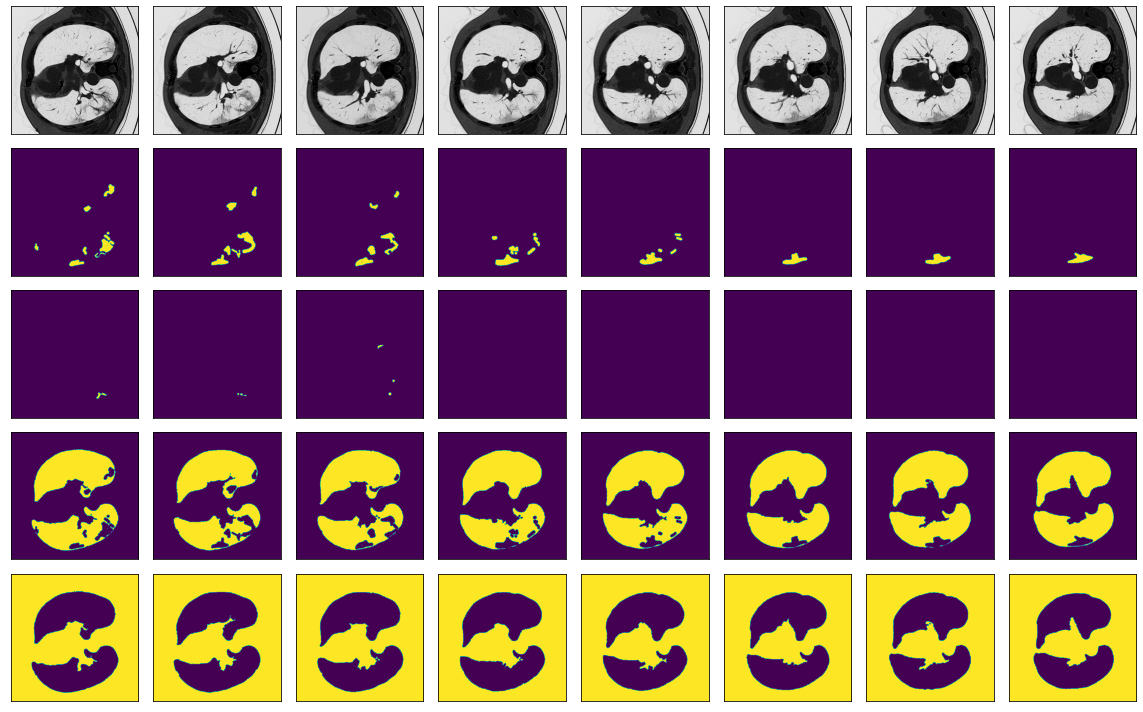

In [5]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

### Images from medseg are individual axial slices:
Classes are same as in radiopedia part

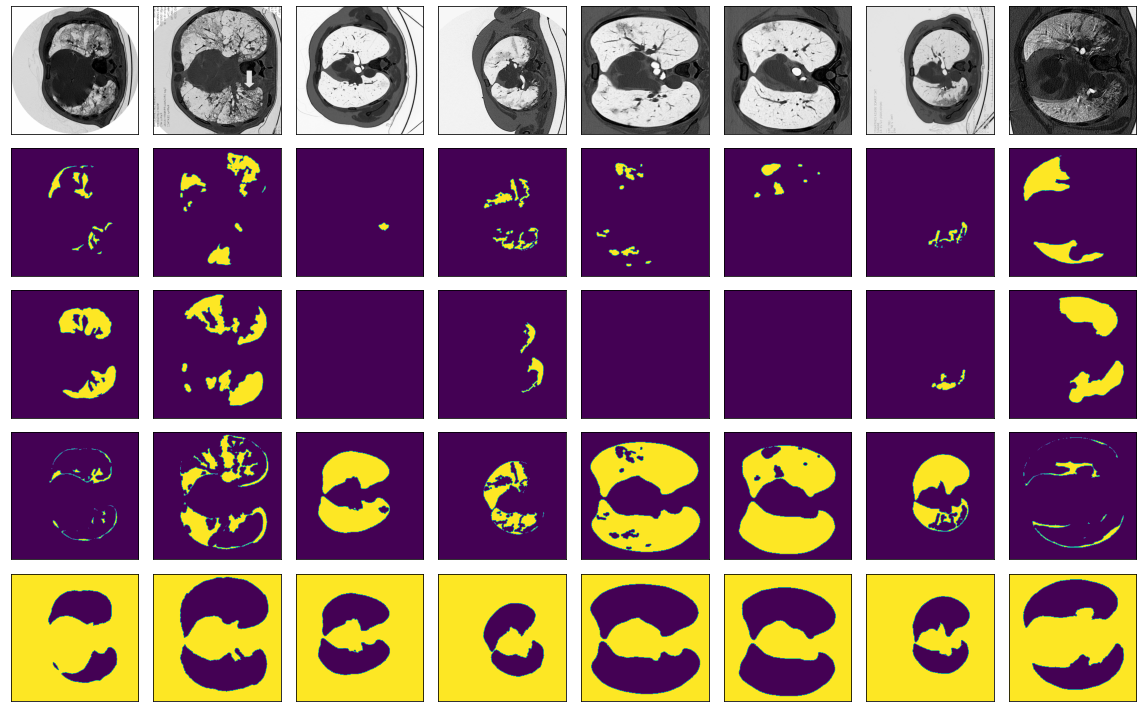

In [6]:
visualize(images_medseg, masks_medseg)

### Test images from medseg are individual axial slices:
make predictions for class 0 "ground glass" and class 1 "consolidation"

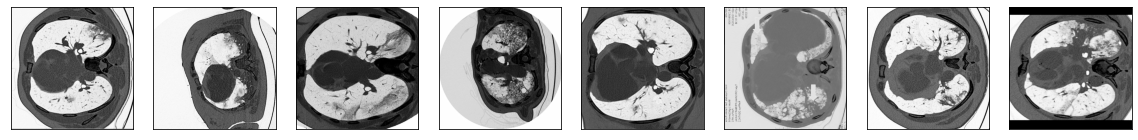

In [7]:
visualize(test_images_medseg)

In [8]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show();

### Plot images hists:
HU (Hounsfield scale) of radiopedia data (blue) vs medseg data (orange):

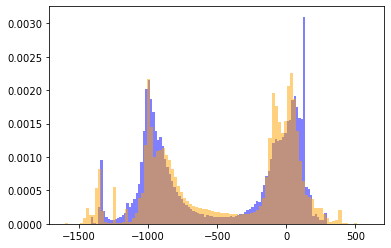

In [9]:
plot_hists(images_radiopedia, images_medseg)

HU (Hounsfield scale) of test medseg data (blue) vs medseg data (orange):

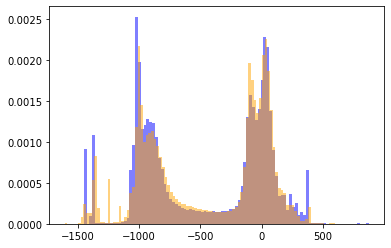

In [10]:
plot_hists(test_images_medseg, images_medseg)

### Preprocess images:

In [11]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


Normalized values of radiopedia data (blue) vs medseg data (orange):

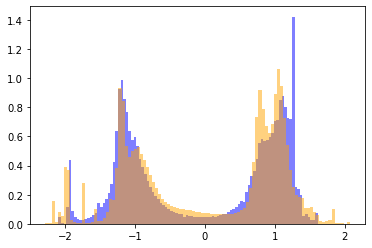

In [12]:
plot_hists(images_radiopedia, images_medseg)

Normalized values of test medseg data (blue) vs medseg data (orange):

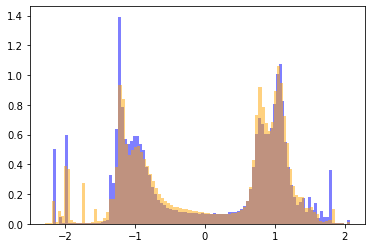

In [13]:
plot_hists(test_images_medseg, images_medseg)

## Split train / val:

In [14]:
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg[train_indexes], masks_radiopedia))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg[val_indexes]

batch_size = len(val_masks)


## Data generator and augmentations:

In [15]:
SOURCE_SIZE = 512
TARGET_SIZE = 224

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode = cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation = cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation = cv2.INTER_NEAREST)
])

# Load data from dataset and form batches

In [16]:
class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloder(tensorflow.keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            image, mask = self.dataset[self.indexes[j]]
            images.append(image)
            masks.append(mask)
        
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0).astype(np.float32)
        
        return (images, masks)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)

train_dataloader = Dataloder(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = batch_size, shuffle = False)

In [17]:
assert train_dataloader[0][0].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 1)
assert train_dataloader[0][1].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 4)

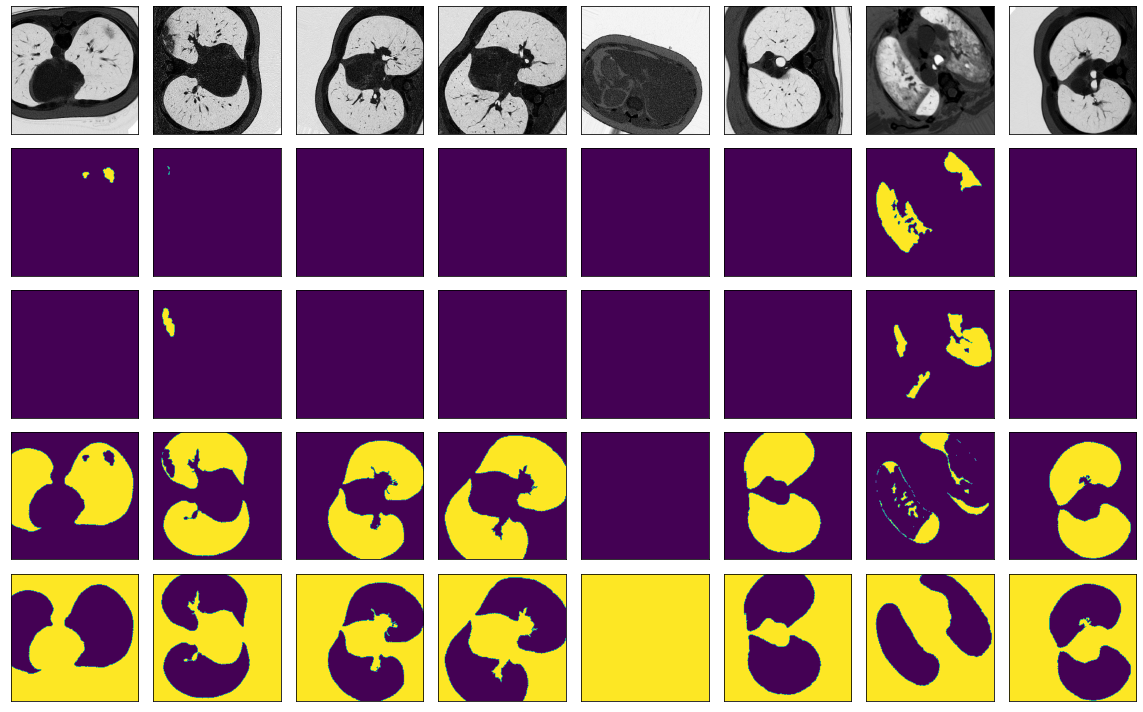

In [18]:
visualize(*next(iter(train_dataloader)))


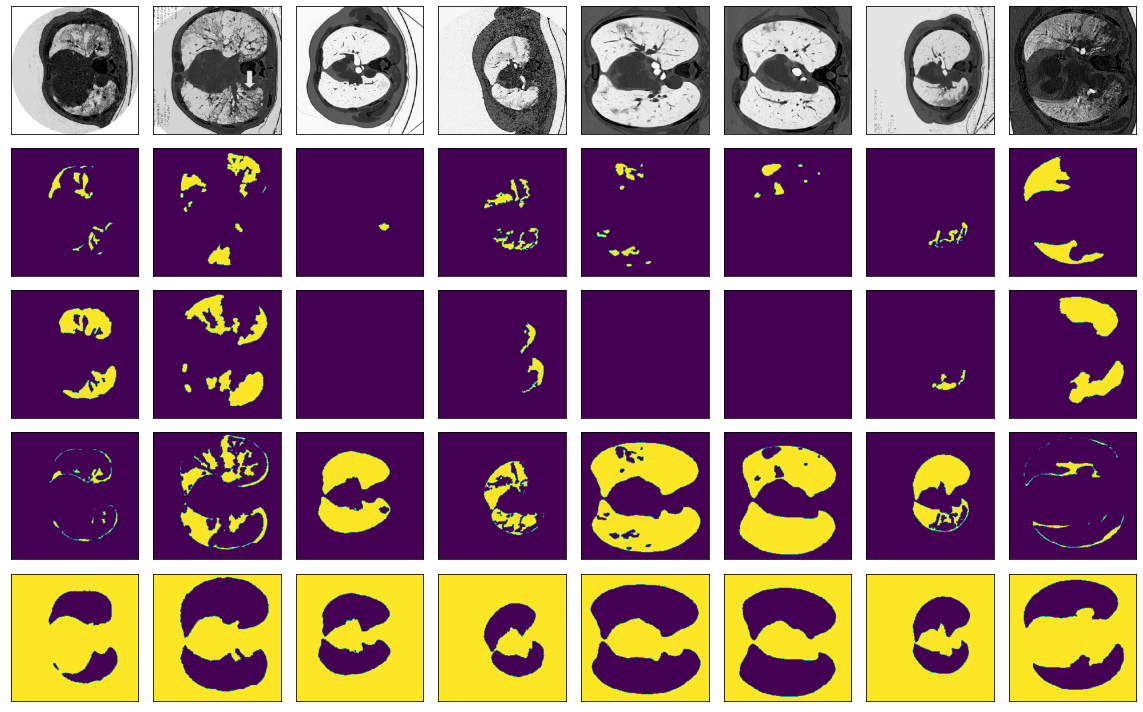

In [19]:
visualize(*next(iter(val_dataloader)))

## Model:

In [38]:
base_model = Unet(backbone_name = 'mobilenetv2',
                  encoder_weights = 'imagenet',
                  classes = 4, 
                  activation = 'softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])
    

model.summary()


/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 3)       6         
_________________________________________________________________
model_1 (Model)              multiple                  8047876   
Total params: 8,047,882
Trainable params: 8,011,786
Non-trainable params: 36,096
_________________________________________________________________


In [21]:
# define f1-score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss=sm.losses.categorical_crossentropy,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'), f1_score])

In [23]:
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'auto',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'auto',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

In [24]:
%%time
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader) * 6,
    epochs = 10,
    validation_data = val_dataloader,
    validation_steps = len(val_dataloader),
    callbacks=[early_stopper, reduce_lr],
    workers = 4)

Train for 222 steps, validate for 1 steps
Epoch 1/10
222/222 [==============================] - 65s 292ms/step - loss: 0.0294 - accuracy: 0.9662 - precision: 0.9798 - recall: 0.9525 - f1_score: 0.9616 - val_loss: 0.4858 - val_accuracy: 0.7207 - val_precision: 0.7207 - val_recall: 0.7207 - val_f1_score: 0.7207
Epoch 2/10
222/222 [==============================] - 52s 234ms/step - loss: 0.0118 - accuracy: 0.9827 - precision: 0.9869 - recall: 0.9804 - f1_score: 0.9836 - val_loss: 0.5041 - val_accuracy: 0.7209 - val_precision: 0.7210 - val_recall: 0.7209 - val_f1_score: 0.7210
Epoch 3/10
222/222 [==============================] - 52s 234ms/step - loss: 0.0104 - accuracy: 0.9851 - precision: 0.9870 - recall: 0.9834 - f1_score: 0.9852 - val_loss: 0.2751 - val_accuracy: 0.8310 - val_precision: 0.8346 - val_recall: 0.8284 - val_f1_score: 0.8315
Epoch 4/10
222/222 [==============================] - 52s 236ms/step - loss: 0.0092 - accuracy: 0.9863 - precision: 0.9878 - recall: 0.9850 - f1_score:

In [25]:
# Save and show training history
df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
df.head(20)

,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score,lr
0,0.029380,0.966159,0.979758,0.952470,0.961625,0.485764,0.720712,0.720713,0.720712,0.720713,0.00100
1,0.011774,0.982718,0.986914,0.980402,0.983643,0.504084,0.720939,0.721025,0.720932,0.720978,0.00100
2,0.010366,0.985073,0.986991,0.983428,0.985204,0.275073,0.830980,0.834561,0.828377,0.831457,0.00100
3,0.009162,0.986294,0.987835,0.984980,0.986403,0.108848,0.914563,0.917497,0.913399,0.915444,0.00100
4,0.008281,0.987413,0.988758,0.986291,0.987521,0.077734,0.926973,0.930499,0.924606,0.927543,0.00100
5,0.008411,0.987276,0.988619,0.986166,0.987389,0.155819,0.879131,0.881997,0.877806,0.879896,0.00100
6,0.007962,0.987789,0.989072,0.986727,0.987896,0.105395,0.912453,0.914808,0.910939,0.912869,0.00100
7,0.008053,0.987745,0.988974,0.986744,0.987856,0.107543,0.909062,0.914380,0.905563,0.909950,0.00100
8,0.007410,0.988554,0.989720,0.987586,0.988651,0.077804,0.924375,0.928086,0.921530,0.924797,0.00025
9,0.007206,0.988784,0.989925,0.987856,0.988888,0.058862,0.939746,0.943810,0.936716,0.940250,0.00025


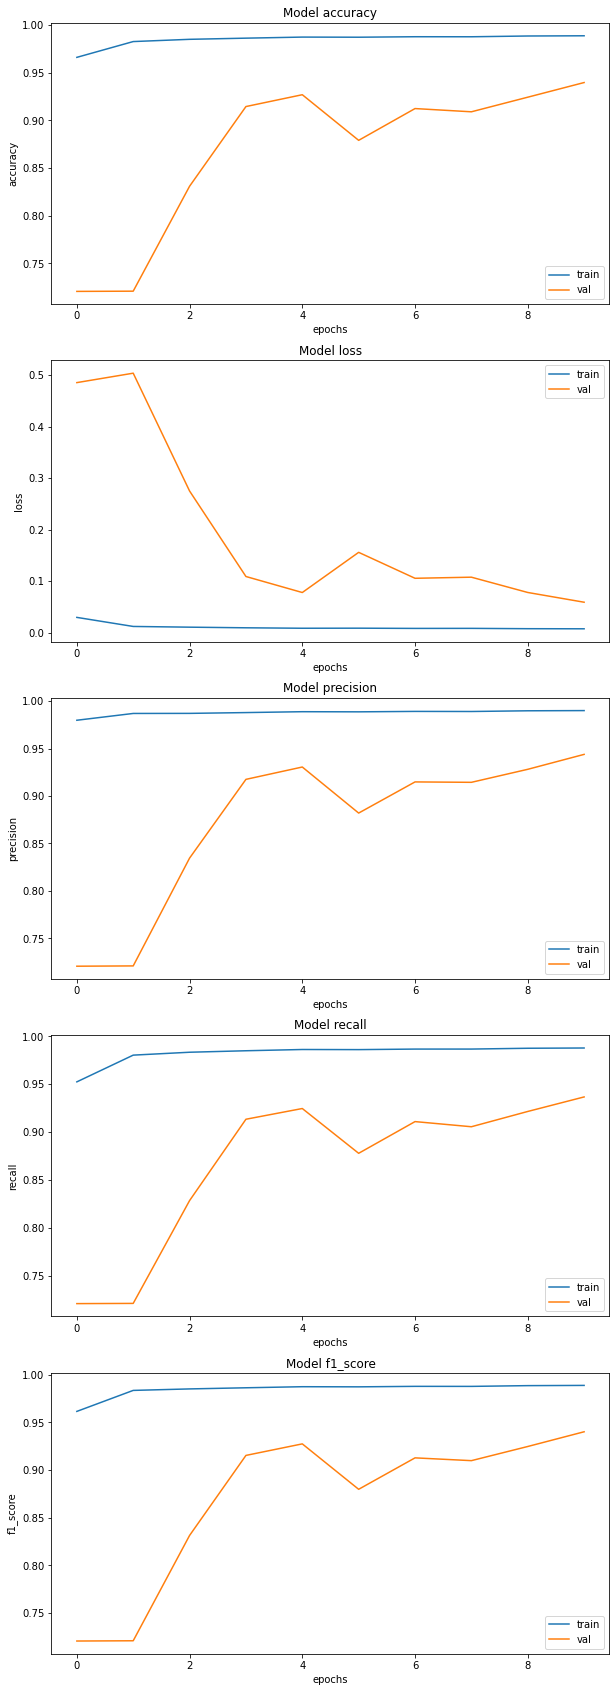

In [26]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, figsize=(10, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'f1_score' ]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-plot.png")

In [35]:
#save model as tf model
model.save('model.h5')

## Load best model and visualize predicions on val:

In [36]:
model = tensorflow.keras.models.load_model('model.h5',
                                           compile=False,
                                           custom_objects={
                                                'categorical_crossentropy': sm.losses.categorical_crossentropy,
                                                'Accuracy': 'accuracy', 
                                                'Precision': tf.keras.metrics.Precision(), 
                                                'Recall': tf.keras.metrics.Recall(),
                                                'F1_Score': f1_score})

model.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss=sm.losses.jaccard_loss)

# yellow is TP, red is FP, green is FN.

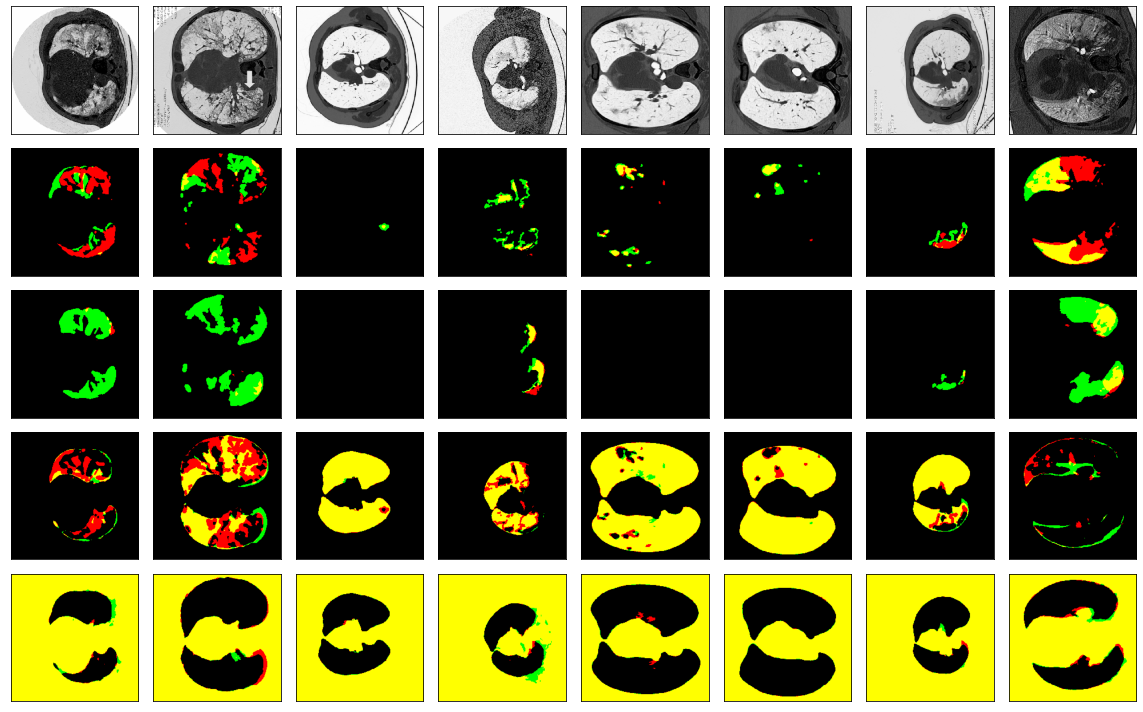

CPU times: user 3.1 s, sys: 24 ms, total: 3.12 s
Wall time: 3.12 s


In [37]:
%%time
input = val_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

## Test preds:

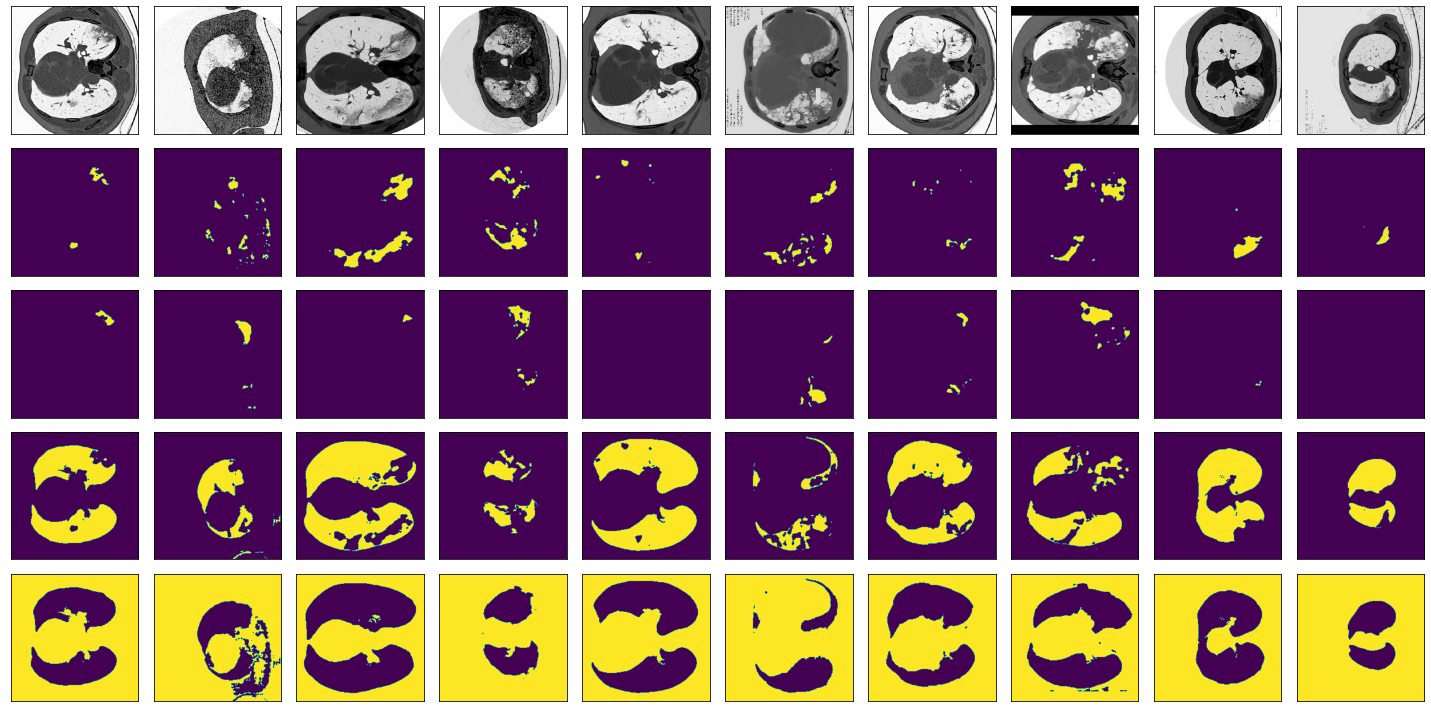

CPU times: user 3.69 s, sys: 35.2 ms, total: 3.73 s
Wall time: 3.71 s


In [30]:
%%time
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
test_preds = model.predict_on_batch(image_batch)
test_masks_prediction = test_preds > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))